<a href="https://colab.research.google.com/github/kgpworks-creator/Car-price-/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import pickle
import warnings
warnings.filterwarnings('ignore')

  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl (99.2 MB)


In [3]:
df = pd.read_csv('/content/car_data.csv')

# Data Cleaning

In [4]:
display(df.head())


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
df.drop(['Unnamed: 0','Location','New_Price'],axis=1,inplace=True)


In [6]:
df.isnull().sum()


,0
Name,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,2
Engine,36
Power,36
Seats,42


In [7]:
manufacturer = df['Name'].str.split(' ',expand=True)
df['Manufacturer'] = manufacturer[0]

In [8]:
curr_time = 2024
df['Year Used']=df['Year'].apply(lambda x:curr_time-x)

In [9]:
df.drop(['Name','Year'],axis=1,inplace=True)

In [10]:
mileage = df['Mileage'].str.split(' ',expand=True)
df['Mileage'] = pd.to_numeric(mileage[0],errors='coerce')
df['Mileage'].fillna(df['Mileage'].astype('float').mean(),inplace=True)

In [11]:
engine = df['Engine'].str.split(' ',expand=True)
df['Engine']=pd.to_numeric(engine[0],errors='coerce')
df['Engine'].fillna(df['Engine'].astype('float').mean(),inplace=True)

In [12]:
power = df['Power'].str.split(' ',expand=True)
df['Power']=pd.to_numeric(power[0],errors='coerce')
df['Power'].fillna(df['Power'].astype('float').mean(),inplace=True)

In [13]:
df['Seats'].fillna(df['Seats'].astype('float').mean(),inplace=True)

In [14]:
df.isnull().sum()


,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,0
Engine,0
Power,0
Seats,0
Price,0
Manufacturer,0


In [15]:
display(df.head())

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer,Year Used
0,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,Maruti,14
1,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai,9
2,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda,13
3,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti,12
4,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi,11


# Data Visualization

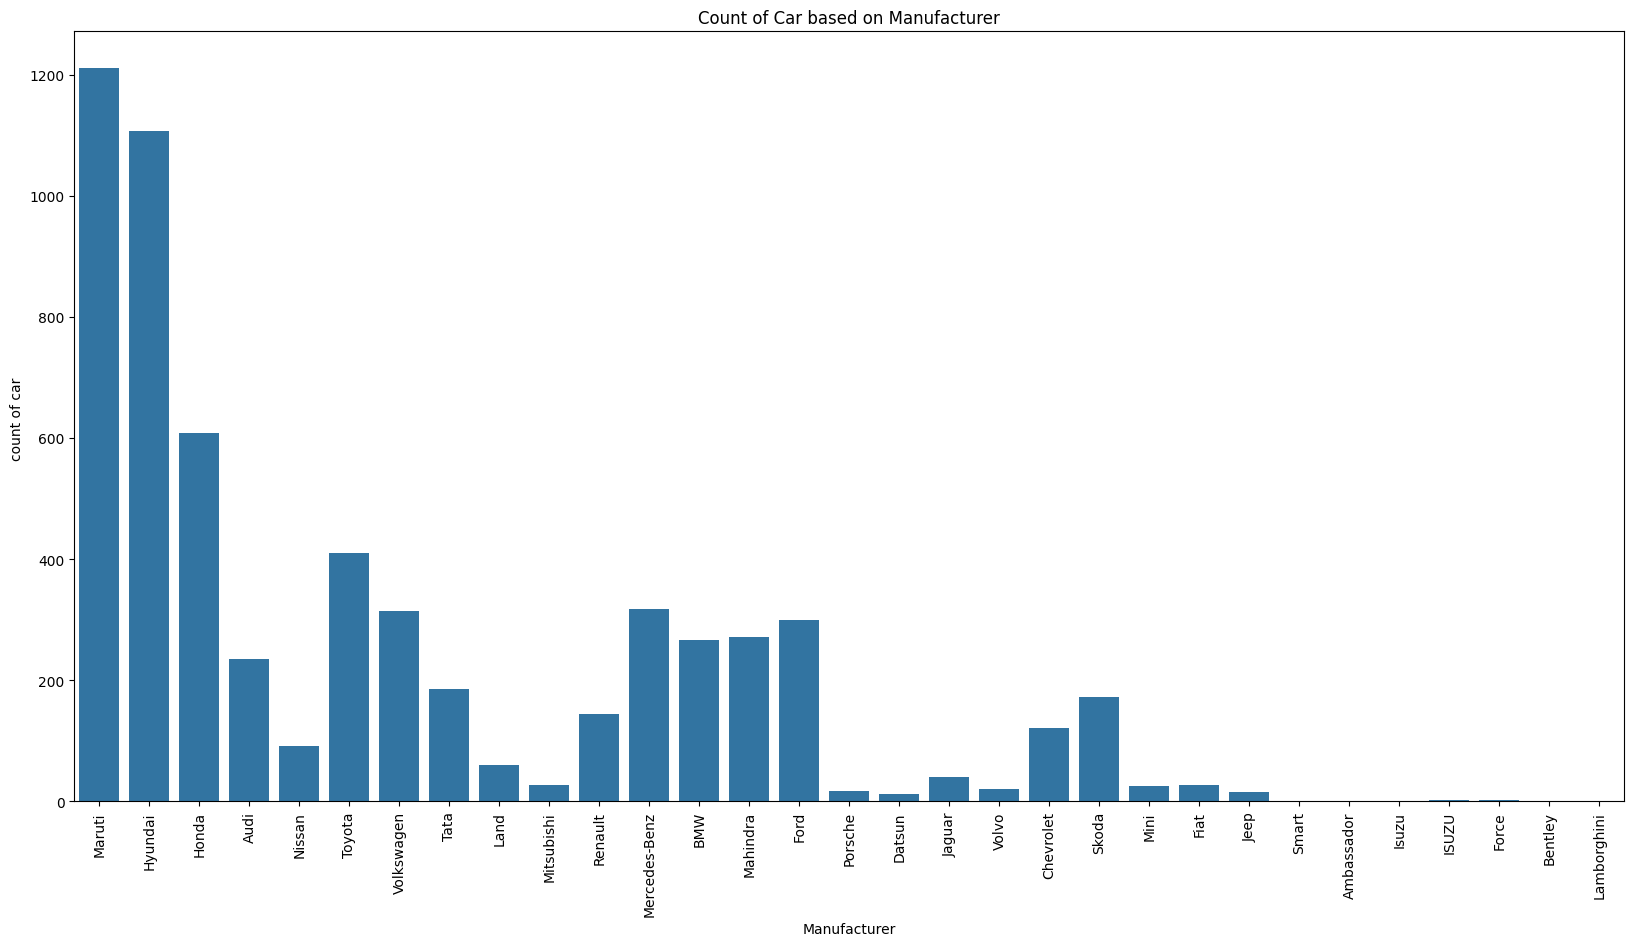

In [16]:
plt.rcParams['figure.figsize']=(20,10)
plot = sns.countplot(x='Manufacturer',data = df)
plt.xticks(rotation=90)
plt.title('Count of Car based on Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('count of car ')
plt.savefig('Count of Car.png')
plt.show()

In [17]:
display(df.head())

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Manufacturer,Year Used
0,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75,Maruti,14
1,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,Hyundai,9
2,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50,Honda,13
3,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,Maruti,12
4,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,Audi,11


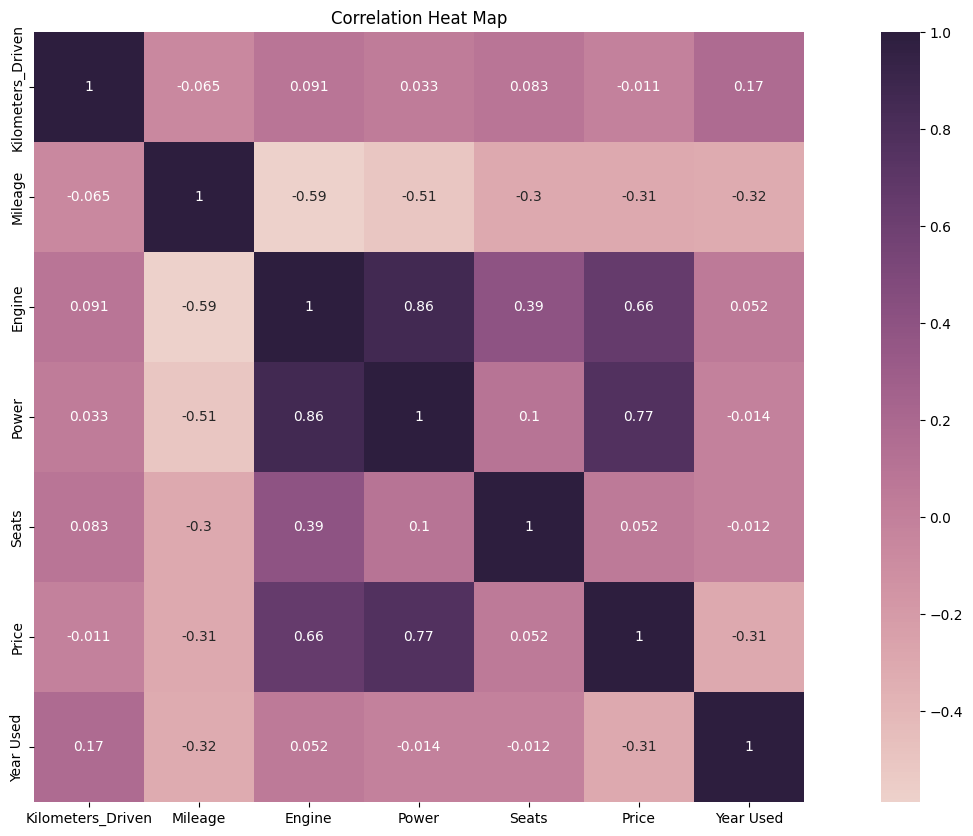

In [18]:
corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True),
            cbar=True, square=True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()


In [19]:
x = df.drop(['Price'],axis=1)
y = df['Price']

# Data Preprocessing

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=45)

In [21]:
x_train = pd.get_dummies(x_train,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_train.shape)

(4213, 42)


In [22]:
x_test = pd.get_dummies(x_test,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_test.shape)

(1806, 38)


In [23]:
miss_col = set(x_train.columns)-set(x_test.columns)
for col in miss_col:
    x_test[col]=0
x_test = x_test[x_train.columns]

In [24]:
print('X_train',x_train.shape)
print('X_test',x_test.shape)

X_train (4213, 42)
X_test (1806, 42)


In [25]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [26]:
display(x.head())

,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Manufacturer,Year Used
0,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,Maruti,14
1,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,Hyundai,9
2,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,Honda,13
3,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,Maruti,12
4,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,Audi,11


In [27]:
display(y.head())

,Price
0,1.75
1,12.50
2,4.50
3,6.00
4,17.74


# Model Fitting

In [28]:
def FitModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    best_params = grid_result.best_params_
    y_pred = grid_result.predict(x_test)
    pickle.dump(grid_result,open(algo_name,'wb'))
    print(' Algorithm Name:',algo_name)
    print('\n Best Params:',best_params)
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

In [29]:
params = {}
FitModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)

 Algorithm Name: Linear Regression

 Best Params: {}

 R2 Score:69.9007092257123%

 Mean Absolute Error: 3.0471807790125234

 Mean Squared Error: 37.35982177380991

 Root Mean Squared Error: 6.112268136609348


In [30]:
params = {}
FitModel(x,y,'Lasso',Lasso(),params,cv=10)

 Algorithm Name: Lasso

 Best Params: {}

 R2 Score:71.83257600126257%

 Mean Absolute Error: 3.392561075193254

 Mean Squared Error: 34.961951373256916

 Root Mean Squared Error: 5.912863212797749


In [31]:
params = {}
FitModel(x,y,'Ridge',Ridge(),params,cv=10)

 Algorithm Name: Ridge

 Best Params: {}

 R2 Score:69.35401729835722%

 Mean Absolute Error: 3.076071076377004

 Mean Squared Error: 38.03838636605653

 Root Mean Squared Error: 6.16752676249212


In [32]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)

 Algorithm Name: Random Forest

 Best Params: {'n_estimators': 109, 'random_state': 45}

 R2 Score:91.53163649907098%

 Mean Absolute Error: 1.6081533617856503

 Mean Squared Error: 10.511096539882896

 Root Mean Squared Error: 3.242082130341996


In [33]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)

 Algorithm Name: Extra Tree

 Best Params: {'n_estimators': 109, 'random_state': 45}

 R2 Score:90.17651794780444%

 Mean Absolute Error: 1.658550448555783

 Mean Squared Error: 12.193095891208156

 Root Mean Squared Error: 3.4918613791512625


In [34]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'XG Boost',XGBRegressor(),params,cv=10)

 Algorithm Name: XG Boost

 Best Params: {'n_estimators': 44, 'random_state': 45}

 R2 Score:89.58825181003%

 Mean Absolute Error: 1.6977104779982224

 Mean Squared Error: 12.923263197395801

 Root Mean Squared Error: 3.5948940453643137


In [35]:
params = {}
FitModel(x,y,'Cat Boost',CatBoostRegressor(verbose=0),params,cv=10)

 Algorithm Name: Cat Boost

 Best Params: {}

 R2 Score:92.75979302702372%

 Mean Absolute Error: 1.5221297680133723

 Mean Squared Error: 8.986684907106117

 Root Mean Squared Error: 2.9977799964483913


In [36]:
params = {}
FitModel(x,y,'Light GBM',LGBMRegressor(),params,cv=10)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 4213, number of used features: 30
[LightGBM] [Info] Start training from score 9.405616
 Algorithm Name: Light GBM

 Best Params: {}

 R2 Score:91.58465644990349%

 Mean Absolute Error: 1.6396858696477548

 Mean Squared Error: 10.445287151601548

 Root Mean Squared Error: 3.2319169468910474


# Boost Model

In [46]:
def BoostModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    AdaBoost = AdaBoostRegressor(estimator=grid_result,learning_rate=1)
    AdaBoost_result = AdaBoost.fit(x_train,y_train)
    y_pred = AdaBoost_result.predict(x_test)
    pickle.dump(AdaBoost_result,open(algo_name,'wb'))
    print(' Algorithm Name:',algo_name)
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

In [47]:
params = {}
BoostModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)

 Algorithm Name: Linear Regression

 R2 Score:51.954186741543175%

 Mean Absolute Error: 3.951546964799001

 Mean Squared Error: 59.63539253380228

 Root Mean Squared Error: 7.722395517830091


In [48]:
params = {}
BoostModel(x,y,'Lasso',Lasso(),params,cv=10)

 Algorithm Name: Lasso

 R2 Score:-19.40538897338515%

 Mean Absolute Error: 5.549435680444632

 Mean Squared Error: 148.20827787373958

 Root Mean Squared Error: 12.174082218949385


In [49]:
params = {}
BoostModel(x,y,'Ridge',Ridge(),params,cv=10)

 Algorithm Name: Ridge

 R2 Score:47.658280632336805%

 Mean Absolute Error: 3.882563668892391

 Mean Squared Error: 64.96755427144937

 Root Mean Squared Error: 8.060245298466379


In [50]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
BoostModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)

 Algorithm Name: Random Forest

 R2 Score:91.05102851272913%

 Mean Absolute Error: 1.6165686037129061

 Mean Squared Error: 11.107636466602377

 Root Mean Squared Error: 3.3328120959037544


In [58]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
BoostModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)

 Algorithm Name: Extra Tree

 R2 Score:91.20416134700223%

 Mean Absolute Error: 1.6155072787081672

 Mean Squared Error: 10.917565031396053

 Root Mean Squared Error: 3.3041738803210787


In [52]:
model_results = []


In [53]:
params = {}
FitModel(x, y, 'Linear Regression', LinearRegression(), params, cv=10)


 Algorithm Name: Linear Regression

 Best Params: {}

 R2 Score:69.9007092257123%

 Mean Absolute Error: 3.0471807790125234

 Mean Squared Error: 37.35982177380991

 Root Mean Squared Error: 6.112268136609348


In [54]:
model_results.append(('Linear Regression', r2_score(y_test, LinearRegression().fit(x_train, y_train).predict(x_test))))


In [55]:
params = {}
FitModel(x, y, 'Lasso', Lasso(), params, cv=10)
model_results.append(('Lasso', r2_score(y_test, Lasso().fit(x_train, y_train).predict(x_test))))

params = {}
FitModel(x, y, 'Ridge', Ridge(), params, cv=10)
model_results.append(('Ridge', r2_score(y_test, Ridge().fit(x_train, y_train).predict(x_test))))

params = {'n_estimators': [44, 109, 314], 'random_state': [45]}
FitModel(x, y, 'Random Forest', RandomForestRegressor(), params, cv=10)
model_results.append(('Random Forest', r2_score(y_test, RandomForestRegressor(n_estimators=314, random_state=45).fit(x_train, y_train).predict(x_test))))


 Algorithm Name: Lasso

 Best Params: {}

 R2 Score:71.83257600126257%

 Mean Absolute Error: 3.392561075193254

 Mean Squared Error: 34.961951373256916

 Root Mean Squared Error: 5.912863212797749
 Algorithm Name: Ridge

 Best Params: {}

 R2 Score:69.35401729835722%

 Mean Absolute Error: 3.076071076377004

 Mean Squared Error: 38.03838636605653

 Root Mean Squared Error: 6.16752676249212
 Algorithm Name: Random Forest

 Best Params: {'n_estimators': 109, 'random_state': 45}

 R2 Score:91.53163649907098%

 Mean Absolute Error: 1.6081533617856503

 Mean Squared Error: 10.511096539882896

 Root Mean Squared Error: 3.242082130341996


In [56]:
best_model_name, best_score = max(model_results, key=lambda x: x[1])
print("\n🏆 Best Model:", best_model_name)
print("R² Score: {:.2f}%".format(best_score * 100))



🏆 Best Model: Random Forest
R² Score: 91.64%


In [57]:
# Reload the saved best model from pickle
import pickle
best_model = pickle.load(open(best_model_name, 'rb'))

y_pred_best = best_model.predict(x_test)
print("\nAccuracy of Best Model (R²): {:.2f}%".format(r2_score(y_test, y_pred_best) * 100))
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred_best)))



Accuracy of Best Model (R²): 91.53%
MAE: 1.6081533617856503
RMSE: 3.242082130341996
